In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display
import time
from tqdm.auto import tqdm

In [50]:
class BetterThanAdolf:
    """
    An evolutionary algorithm class that uses triangles to replicate an image. The algorithm evolves a population of 
    'chromosomes', each representing a sequence of triangles with specific colors and positions, to minimize the 
    difference between the generated image and a target image.
    """
    def __init__(self, target_image_path, num_triangles, pop_size, iter_count, offspring_count, parent_count, 
                 position_mutation_rate, color_mutation_rate, add_triangles_interval=100, log_interval=200, 
                 mutation_prob=0.3, frame_interval=10):
        """
        Initializes the algorithm with given parameters.

        :param target_image_path: Path to the target image file.
        :param num_triangles: The number of triangles in each chromosome.
        :param pop_size: The size of the population.
        :param iter_count: The number of iterations for the algorithm to run.
        :param offspring_count: The number of offspring generated each iteration.
        :param parent_count: The number of parents selected for breeding.
        :param position_mutation_rate: The mutation rate for triangle positions.
        :param color_mutation_rate: The mutation rate for triangle colors.
        :param add_triangles_interval: Interval at which new triangles are added to the image.
        :param log_interval: Interval for logging and displaying the image.
        :param mutation_prob: Probability of mutation occurring.
        :param frame_interval: Interval for saving frames for a gif.
        """
        self.best_seq_colors = None
        self.best_seq_triangles = None
        self.pop_colors = None
        self.pop_triangles = None
        self.log_values = None
        self.target_image = Image.open(target_image_path)
        self.img_width, self.img_height = self.target_image.size
        self.current_img = Image.new("RGB", (self.img_width, self.img_height))
        self.chromo_len = num_triangles
        self.pop_size = pop_size
        self.iter_count = iter_count
        self.offspring_count = offspring_count
        self.parent_count = parent_count
        self.mut_prob = mutation_prob
        self.frame_interval = frame_interval
        self.add_triangles_interval = add_triangles_interval
        self.log_interval = log_interval
        self.color_domain = np.array([255, 255, 255, 255])
        self.position_domain = np.array([self.img_width - 1, self.img_height - 1])
        self.triangle_count = 0
        self.pos_mutation_rate = position_mutation_rate
        self.color_mutation_rate = color_mutation_rate
        
    def reset_current_image(self):
        """ Resets the current image to a blank image. """
        self.current_img = Image.new("RGB", (self.img_width, self.img_height))
        
    @staticmethod
    def display_image(image):
        """ Displays the given image. """
        display(image)
    
    @staticmethod
    def save_image(image, filepath):
        """ Saves the given image to a file. """
        img = Image.fromarray(np.asarray(image))
        img.save(filepath)
    
    @staticmethod
    def draw_triangle(triangle, color, img):
        """
        Draws a triangle on the given image.

        :param triangle: Coordinates of the triangle's vertices.
        :param color: Color of the triangle (RGBA).
        :param img: Image on which to draw the triangle.
        """
        draw = ImageDraw.Draw(img, "RGBA")
        draw.polygon([tuple(elem) for elem in triangle], color)
    
    def create_image(self, triangles, colors, img):
        """
        Creates an image with the given triangles and colors.

        :param img: Image on which to draw the triangles.
        :param triangles: Array of triangle coordinates.
        :param colors: Array of triangle colors.
        :return: An image with the drawn triangles.
        """
        for i in range(triangles.shape[0]):
            self.draw_triangle(triangles[i], tuple(colors[i]), img)
            
        return img
    
    def create_new_image(self, triangles, colors):
        """
        Creates a new image with the given triangles and colors.
        
        :param triangles: 
        :param colors: 
        :return: 
        """
        img = self.current_img.copy()
        return self.create_image(triangles, colors, img)
    
    def update_current_img(self, triangles, colors):
        """ Updates the current image with the given triangles and colors. """
        for i in range(triangles.shape[0]):
            self.draw_triangle(triangles[i], tuple(colors[i]), self.current_img)
    
    def calculate_image_distance(self, triangles, colors):
        """
        Calculates the Mean Squared Error between the target image and an image created from the given triangles and colors.

        :param triangles: Array of triangle coordinates.
        :param colors: Array of triangle colors.
        :return: The calculated MSE.
        """
        img = self.create_new_image(triangles, colors)
        target_arr = np.asarray(self.target_image, dtype=int)
        img_arr = np.asarray(img, dtype=int)
        return np.sum((target_arr - img_arr) ** 2) / (self.img_width * self.img_height)
    
    def generate_random_population(self):
        """ Generates a random population of triangles and colors. """
        self.pop_triangles = np.around(
            self.position_domain * np.random.rand(self.pop_size, self.chromo_len, 3, 2))
        self.pop_colors = np.around(
            self.color_domain * np.random.rand(self.pop_size, self.chromo_len, 4))
        
    def evolve(self, debug=False):
        """
        Evolves the population over the specified number of iterations, aiming to minimize the objective function 
        (MSE in this case). It uses a combination of selection, crossover, and mutation to evolve the population.

        :param debug: If True, displays additional debugging information.
        """
        self.best_seq_triangles = []
        self.best_seq_colors = []
        
        best_triangles = np.empty((1, self.chromo_len, 3, 2))
        best_colors = np.empty((1, self.chromo_len, 4))
        best_mse = np.Inf
        
        self.log_values = np.empty((self.iter_count, 4))
        
        # Generating an initial population
        self.generate_random_population()
        
        current_population_objective_values = np.zeros(self.pop_size)
        
        for i in range(self.pop_size):
            current_population_objective_values[i] = self.calculate_image_distance(self.pop_triangles[i, :].astype(int), self.pop_colors[i, :].astype(int))
            
        for iteration in tqdm(range(self.iter_count)):
            # Parent selection and offspring generation
            fit_values = current_population_objective_values.max() - current_population_objective_values
            fit_values = fit_values / fit_values.sum() if fit_values.sum() > 0 else np.ones(self.pop_size) / self.pop_size
            parent_indices = np.random.choice(self.pop_size, (self.offspring_count, self.parent_count), True, fit_values).astype(np.int64)

            children_triangles = np.zeros((self.offspring_count, self.chromo_len, 3, 2))
            children_colors = np.zeros((self.offspring_count, self.chromo_len, 4))

            for i in range(self.offspring_count):
                children_triangles[i, :] = self.pop_triangles[parent_indices[i, :], :].mean(axis=0) 
                children_colors[i, :] = self.pop_colors[parent_indices[i, :], :].mean(axis=0)

            # Mutation
            for i in range(self.offspring_count):
                for j in range(self.chromo_len):
                    mut_vec_pos = (np.random.rand(3) < self.mut_prob).astype(int)
                    children_triangles[i][j][:, 0] += mut_vec_pos * (self.pos_mutation_rate * self.img_width * np.random.randn(3))
                    children_triangles[i][j][:, 1] += mut_vec_pos * (self.pos_mutation_rate * self.img_height * np.random.randn(3))
                    
            for i in range(self.offspring_count):
                for j in range(self.chromo_len):
                    mut_vec_col = (np.random.rand(4) < self.mut_prob).astype(int)
                    children_colors[i][j] += mut_vec_col * (self.color_mutation_rate * 255 * np.random.randn(4))

            # Domain checks
            children_triangles[children_triangles < 0] = 0
            children_triangles[:,:,0][children_triangles[:,:,0] > self.position_domain[0]] = self.position_domain[0]
            children_triangles[:,:,1][children_triangles[:,:,1] > self.position_domain[1]] = self.position_domain[1]
            children_colors[children_colors < 0] = 0
            children_colors[children_colors > self.color_domain[1]] = self.color_domain[1]

            # Children evaluation
            children_mse_values = np.zeros(self.offspring_count)
            for i in range(self.offspring_count):
                children_mse_values[i] = self.calculate_image_distance(children_triangles[i, :].astype(int), children_colors[i, :].astype(int))

            # Population update (Mu + Lambda Replacement)
            current_population_objective_values = np.hstack([current_population_objective_values, children_mse_values])
            self.pop_triangles = np.vstack([self.pop_triangles, children_triangles])         
            self.pop_colors = np.vstack([self.pop_colors, children_colors])

            sorted_indices = np.argsort(current_population_objective_values)
            self.pop_triangles = self.pop_triangles[sorted_indices[:self.pop_size], :]
            self.pop_colors = self.pop_colors[sorted_indices[:self.pop_size], :]
            current_population_objective_values = current_population_objective_values[sorted_indices[:self.pop_size]]

            # Update best solution
            if best_mse > current_population_objective_values[0]:
                best_triangles = self.pop_triangles[0, :]
                best_colors = self.pop_colors[0, :]
                best_mse = current_population_objective_values[0]
                
            self.log_values[iteration, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
            
            # Reset population and update image
            if (iteration + 1) % self.add_triangles_interval == 0:
                self.update_current_img(best_triangles.astype(int), best_colors.astype(int))
                self.generate_random_population()
                self.triangle_count += self.chromo_len
                current_population_objective_values = np.zeros(self.pop_size)
                for i in range(self.pop_size):
                    current_population_objective_values[i] = self.calculate_image_distance(self.pop_triangles[i, :].astype(int), self.pop_colors[i, :].astype(int))
                self.best_seq_triangles.append(best_triangles.astype(int))
                self.best_seq_colors.append(best_colors.astype(int))
                best_triangles = np.empty((1, self.chromo_len, 3, 2))
                best_colors = np.empty((1, self.chromo_len, 4))
                best_mse = np.Inf
            
            if debug and iteration % self.log_interval == 0:
                self.display_image(self.current_img)
                print(f"Iteration {iteration}: Best score = {current_population_objective_values.min():.8f}, Mean score = {current_population_objective_values.mean():.8f}.")
    
    def show_statistics(self):
        """
        Displays statistics of the evolutionary process, including minimum, average, and maximum MSE values per iteration.
        """
        plt.figure(figsize=(18, 4))
        plt.plot(self.log_values[:, 0], 'r-', label='Min MSE')
        plt.plot(self.log_values[:, 1], 'g-', label='Max MSE')
        plt.plot(self.log_values[:, 2], 'b-', label='Avg MSE')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Value')
        plt.title('MSE Statistics Over Iterations')
        plt.legend()
        plt.show()
        print(f'Lowest MSE value: {self.log_values[:,0].min()}')
        
    def save_results(self, title):
        """
        Saves the final result as an image and optionally creates a GIF to show the evolution process.

        :param title: Base filename for saving the result.
        """
        self.result = self.create_new_image(self.best_seq_triangles, self.best_seq_colors)
        self.save_image(self.result, f'{title}.jpg')

In [ ]:
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

class BetterThanAdolf:
    """
    An evolutionary algorithm class that uses triangles to replicate an image.
    The algorithm evolves a population of 'chromosomes', each representing a sequence
    of triangles with specific colors and positions, to minimize the difference
    between the generated image and a target image.
    """

    def __init__(self, target_image_path, num_triangles, pop_size, iter_count, offspring_count, parent_count, 
                 position_mutation_rate, color_mutation_rate, add_triangles_interval=100, log_interval=200, 
                 mutation_prob=0.3, frame_interval=10):
        """
        Initializes the algorithm with given parameters.

        Parameters:
        target_image_path (str): Path to the target image file.
        num_triangles (int): The number of triangles in each chromosome.
        pop_size (int): The size of the population.
        iter_count (int): The number of iterations for the algorithm to run.
        offspring_count (int): The number of offspring generated each iteration.
        parent_count (int): The number of parents selected for breeding.
        position_mutation_rate (float): The mutation rate for triangle positions.
        color_mutation_rate (float): The mutation rate for triangle colors.
        add_triangles_interval (int): Interval at which new triangles are added to the image.
        log_interval (int): Interval for logging and displaying the image.
        mutation_prob (float): Probability of mutation occurring.
        frame_interval (int): Interval for saving frames for a gif.
        """
        self.target_image = Image.open(target_image_path)
        self.img_width, self.img_height = self.target_image.size
        self.current_img = Image.new("RGB", (self.img_width, self.img_height))
        self.chromo_len = num_triangles
        self.pop_size = pop_size
        self.iter_count = iter_count
        self.offspring_count = offspring_count
        self.parent_count = parent_count
        self.mut_prob = mutation_prob
        self.frame_interval = frame_interval
        self.add_triangles_interval = add_triangles_interval
        self.log_interval = log_interval
        self.color_domain = np.array([255, 255, 255, 255])
        self.position_domain = np.array([self.img_width - 1, self.img_height - 1])
        self.triangle_count = 0
        self.pos_mutation_rate = position_mutation_rate
        self.color_mutation_rate = color_mutation_rate

    @staticmethod
    def display_image(image):
        """ Displays the given image. """
        image.show()

    @staticmethod
    def save_image(image, filepath):
        """ Saves the given image to a file. """
        image.save(filepath)

    @staticmethod
    def draw_triangle(triangle, color, img):
        """
        Draws a triangle on the given image.

        Parameters:
        triangle (array): Coordinates of the triangle's vertices.
        color (tuple): Color of the triangle (RGBA).
        img (Image): Image on which to draw the triangle.
        """
        draw = ImageDraw.Draw(img, "RGBA")
        coords = tuple(map(tuple, triangle))
        draw.polygon(coords, color)

    def create_image(self, triangles, colors, img):
        """
        Creates an image with the given triangles and colors.

        Parameters:
        img (Image): Image on which to draw the triangles.
        triangles (array): Array of triangle coordinates.
        colors (array): Array of triangle colors.

        Returns:
        Image: An image with the drawn triangles.
        """
        for i in range(triangles.shape[0]):
            self.draw_triangle(triangles[i], tuple(colors[i]), img)
        return img

    def create_new_image(self, triangles, colors):
        """
        Creates a new image with the given triangles and colors.

        Parameters:
        triangles (array): Array of triangle coordinates.
        colors (array): Array of triangle colors.

        Returns:
        Image: A new image with the drawn triangles.
        """
        img = self.current_img.copy()
        return self.create_image(triangles, colors, img)

    def update_current_img(self, triangles, colors):
        """
        Updates the current image with the given triangles and colors.

        Parameters:
        triangles (array): Array of triangle coordinates.
        colors (array): Array of triangle colors.
        """
        for i in range(triangles.shape[0]):
            self.draw_triangle(triangles[i], tuple(colors[i]), self.current_img)

    def calculate_image_distance(self, triangles, colors):
        """
        Calculates the Mean Squared Error between the target image and an image created from the given triangles and colors.

        Parameters:
        triangles (array): Array of triangle coordinates.
        colors (array): Array of triangle colors.

        Returns:
        float: The calculated MSE.
        """
        img = self.create_new_image(triangles, colors)
        target_arr = np.asarray(self.target_image, dtype=int)
        img_arr = np.asarray(img, dtype=int)
        return np.sum((target_arr - img_arr) ** 2) / (self.img_width * self.img_height)

    def generate_random_population(self):
        """ Generates a random population of triangles and colors. """
        self.pop_triangles = np.around(
            self.position_domain * np.random.rand(self.pop_size, self.chromo_len, 3, 2))
        self.pop_colors = np.around(
            self.color_domain * np.random.rand(self.pop_size, self.chromo_len, 4))

    def select_parents(self, current_population_objective_values):
        """
        Selects parents for generating offspring based on fitness values.

        Parameters:
        current_population_objective_values (array): The objective values (MSE) of the current population.

        Returns:
        array: Indices of selected parents.
        """
        fit_values = current_population_objective_values.max() - current_population_objective_values
        fit_values = fit_values / fit_values.sum() if fit_values.sum() > 0 else np.ones(self.pop_size) / self.pop_size
        return np.random.choice(self.pop_size, (self.offspring_count, self.parent_count), True, fit_values).astype(np.int64)

    def generate_offspring(self, parent_indices):
        """
        Generates offspring from the selected parents.

        Parameters:
        parent_indices (array): Indices of parents selected for breeding.

        Returns:
        tuple: Arrays of offspring triangles and colors.
        """
        children_triangles = np.zeros((self.offspring_count, self.chromo_len, 3, 2))
        children_colors = np.zeros((self.offspring_count, self.chromo_len, 4))
        for i in range(self.offspring_count):
            children_triangles[i, :] = self.pop_triangles[parent_indices[i, :], :].mean(axis=0)
            children_colors[i, :] = self.pop_colors[parent_indices[i, :], :].mean(axis=0)
        return children_triangles, children_colors

    def mutate(self, children_triangles, children_colors):
        """
        Mutates the positions and colors of the triangles in the offspring.

        Parameters:
        children_triangles (array): Offspring triangles to mutate.
        children_colors (array): Offspring colors to mutate.
        """
        for i in range(self.offspring_count):
            self.mutate_positions(children_triangles[i])
            self.mutate_colors(children_colors[i])

    def mutate_positions(self, triangles):
        """
        Applies mutations to the positions of the triangles.

        Parameters:
        triangles (array): Triangles whose positions to mutate.
        """
        for j in range(self.chromo_len):
            mut_vec_pos = (np.random.rand(3) < self.mut_prob).astype(int)
            triangles[j][:, 0] += mut_vec_pos * (self.pos_mutation_rate * self.img_width * np.random.randn(3))
            triangles[j][:, 1] += mut_vec_pos * (self.pos_mutation_rate * self.img_height * np.random.randn(3))

    def mutate_colors(self, colors):
        """
        Applies mutations to the colors of the triangles.

        Parameters:
        colors (array): Colors to mutate.
        """
        for j in range(self.chromo_len):
            mut_vec_col = (np.random.rand(4) < self.mut_prob).astype(int)
            colors[j] += mut_vec_col * (self.color_mutation_rate * 255 * np.random.randn(4))

    def apply_domain_constraints(self, children_triangles, children_colors):
        """
        Ensures that the triangles and colors stay within their respective domains.

        Parameters:
        children_triangles (array): Offspring triangles to check.
        children_colors (array): Offspring colors to check.
        """
        children_triangles[children_triangles < 0] = 0
        children_triangles[:,:,0][children_triangles[:,:,0] > self.position_domain[0]] = self.position_domain[0]
        children_triangles[:,:,1][children_triangles[:,:,1] > self.position_domain[1]] = self.position_domain[1]
        children_colors[children_colors < 0] = 0
        children_colors[children_colors > self.color_domain[1]] = self.color_domain[1]

    def evaluate_children(self, children_triangles, children_colors):
        """
        Calculates the MSE for each child in the offspring.

        Parameters:
        children_triangles (array): Offspring triangles.
        children_colors (array): Offspring colors.

        Returns:
        array: MSE values for each child.
        """
        children_mse_values = np.zeros(self.offspring_count)
        for i in range(self.offspring_count):
            children_mse_values[i] = self.calculate_image_distance(children_triangles[i].astype(int), children_colors[i].astype(int))
        return children_mse_values

    def update_population(self, current_population_objective_values, children_mse_values, children_triangles, children_colors):
        """
        Updates the population with the new offspring.

        Parameters:
        current_population_objective_values (array): Objective values of the current population.
        children_mse_values (array): MSE values of the children.
        children_triangles (array): Triangles of the children.
        children_colors (array): Colors of the children.

        Returns:
        array: Updated objective values of the population.
        """
        current_population_objective_values = np.hstack([current_population_objective_values, children_mse_values])
        self.pop_triangles = np.vstack([self.pop_triangles, children_triangles])
        self.pop_colors = np.vstack([self.pop_colors, children_colors])
        sorted_indices = np.argsort(current_population_objective_values)
        self.pop_triangles = self.pop_triangles[sorted_indices[:self.pop_size], :]
        self.pop_colors = self.pop_colors[sorted_indices[:self.pop_size], :]
        current_population_objective_values = current_population_objective_values[sorted_indices[:self.pop_size]]
        return current_population_objective_values

    def update_best_solution(self, current_population_objective_values, best_mse, best_triangles, best_colors):
        """
        Updates the best solution found so far if a better one is found.

        Parameters:
        current_population_objective_values (array): Objective values of the current population.
        best_mse (float): Best MSE value found so far.
        best_triangles (array): Best triangles found so far.
        best_colors (array): Best colors found so far.

        Returns:
        tuple: Updated best MSE, triangles, and colors.
        """
        if best_mse > current_population_objective_values[0]:
            best_triangles = self.pop_triangles[0, :]
            best_colors = self.pop_colors[0, :]
            best_mse = current_population_objective_values[0]
        return best_mse, best_triangles, best_colors

    def log_and_debug(self, iteration, current_population_objective_values):
        """
        Handles logging and displaying images for debugging purposes.

        Parameters:
        iteration (int): Current iteration number.
        current_population_objective_values (array): Objective values of the current population.
        """
        self.display_image(self.current_img)
        print(f"Iteration {iteration}: Best score = {current_population_objective_values.min():.8f}, Mean score = {current_population_objective_values.mean():.8f}.")

    def show_statistics(self):
        """
        Displays statistics of the evolutionary process, including minimum, average, and maximum MSE values per iteration.
        """
        plt.figure(figsize=(18, 4))
        plt.plot(self.log_values[:, 0], 'r-', label='Min MSE')
        plt.plot(self.log_values[:, 1], 'g-', label='Max MSE')
        plt.plot(self.log_values[:, 2], 'b-', label='Avg MSE')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Value')
        plt.title('MSE Statistics Over Iterations')
        plt.legend()
        plt.show()

    def evolve(self, debug=False):
        """
        Evolves the population over the specified number of iterations, aiming to minimize the MSE.

        Parameters:
        debug (bool): If True, displays additional debugging information.
        """
        self.best_seq_triangles = []
        self.best_seq_colors = []
        best_triangles = np.empty((1, self.chromo_len, 3, 2))
        best_colors = np.empty((1, self.chromo_len, 4))
        best_mse = np.Inf
        self.log_values = np.empty((self.iter_count, 4))
        self.generate_random_population()
        current_population_objective_values = np.zeros(self.pop_size)
        for i in range(self.pop_size):
            current_population_objective_values[i] = self.calculate_image_distance(self.pop_triangles[i, :].astype(int), self.pop_colors[i, :].astype(int))

        for iteration in tqdm(range(self.iter_count)):
            parent_indices = self.select_parents(current_population_objective_values)
            children_triangles, children_colors = self.generate_offspring(parent_indices)
            self.mutate(children_triangles, children_colors)
            self.apply_domain_constraints(children_triangles, children_colors)
            children_mse_values = self.evaluate_children(children_triangles, children_colors)
            current_population_objective_values = self.update_population(current_population_objective_values, children_mse_values, children_triangles, children_colors)
            best_mse, best_triangles, best_colors = self.update_best_solution(current_population_objective_values, best_mse, best_triangles, best_colors)
            self.log_values[iteration, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
            
            if (iteration + 1) % self.add_triangles_interval == 0:
                self.update_current_img(best_triangles.astype(int), best_colors.astype(int))
                self.generate_random_population()
                self.triangle_count += self.chromo_len
                current_population_objective_values = np.zeros(self.pop_size)
                for i in range(self.pop_size):
                    current_population_objective_values[i] = self.calculate_image_distance(self.pop_triangles[i, :].astype(int), self.pop_colors[i, :].astype(int))
                self.best_seq_triangles.append(best_triangles.astype(int))
                self.best_seq_colors.append(best_colors.astype(int))
                best_triangles = np.empty((1, self.chromo_len, 3, 2))
                best_colors = np.empty((1, self.chromo_len, 4))
                best_mse = np.Inf
            
            if debug and iteration % self.log_interval == 0:
                self.log_and_debug(iteration, current_population_objective_values)

    def save_results(self, title):
        self.result = self.create_new_image(self.best_seq_triangles[-1], self.best_seq_colors[-1])
        self.save_image(self.result, f'{title}.jpg')


In [51]:
num_triangles = 2
population_size = 10
number_of_iterations = 50000
number_of_offspring = 200
number_of_parents = 2
position_mutation_rate = 1/6
color_mutation_rate = 1/6
add_triangles_interval = 250
log_interval = 5000
mutation_probability = 0.3
frame_interval = 50

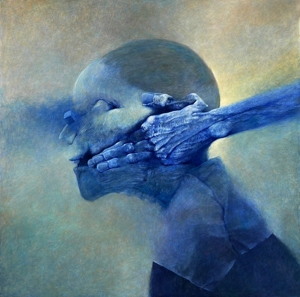

In [52]:
args = [num_triangles, population_size, number_of_iterations, number_of_offspring, number_of_parents, position_mutation_rate, color_mutation_rate, add_triangles_interval, log_interval, mutation_probability, frame_interval]

beksinski = BetterThanAdolf('beksinski.jpg', *args)
beksinski.display_image(beksinski.target_image)

  0%|          | 0/50000 [00:00<?, ?it/s]

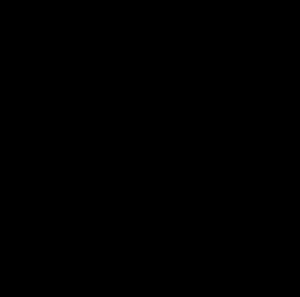

Iteration 0: Best score = 37149.23848485, Mean score = 39532.95041077.


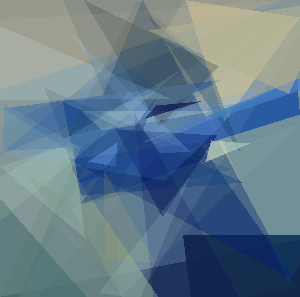

Iteration 5000: Best score = 955.43455668, Mean score = 978.25453984.


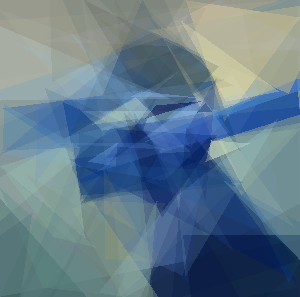

Iteration 10000: Best score = 657.34777778, Mean score = 677.18377329.


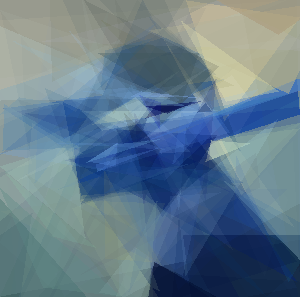

Iteration 15000: Best score = 557.94298541, Mean score = 565.29912682.


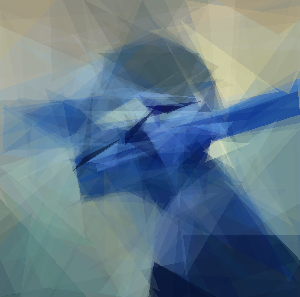

Iteration 20000: Best score = 473.80350168, Mean score = 502.04242761.


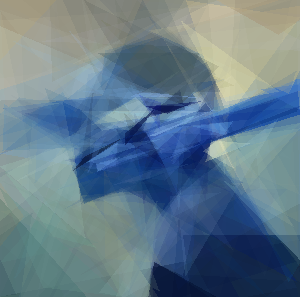

Iteration 25000: Best score = 444.40675645, Mean score = 458.01087654.


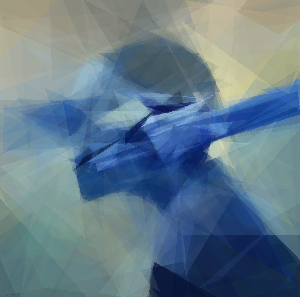

Iteration 30000: Best score = 384.39542088, Mean score = 395.20568575.


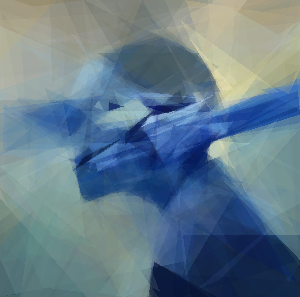

Iteration 35000: Best score = 355.82441077, Mean score = 366.74625589.


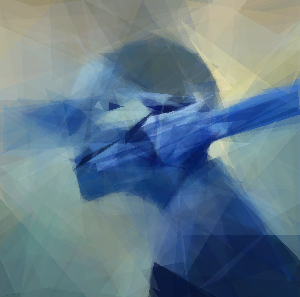

Iteration 40000: Best score = 348.95173962, Mean score = 369.49175309.


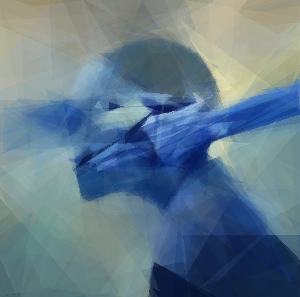

Iteration 45000: Best score = 322.65563412, Mean score = 334.03843322.


In [53]:
beksinski.evolve(debug=True)

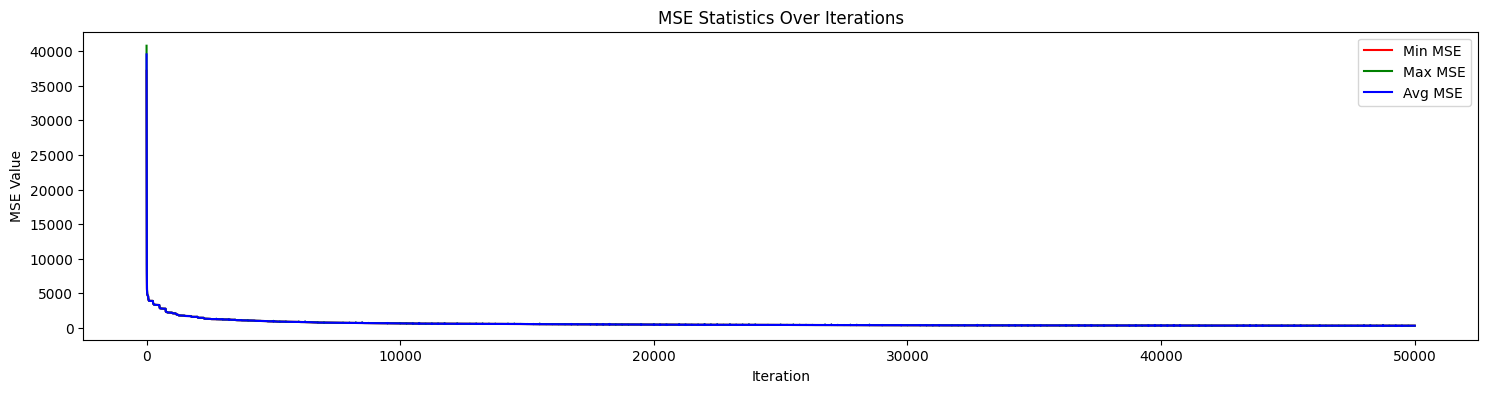

Lowest MSE value: 310.80654320987657


In [54]:
beksinski.show_statistics()

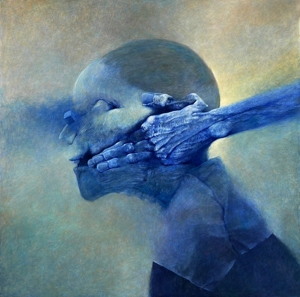

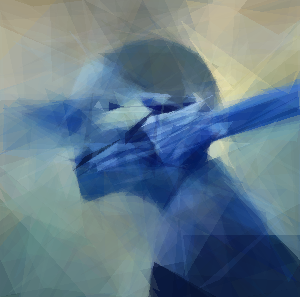

In [55]:
beksinski.display_image(beksinski.target_image)
beksinski.display_image(beksinski.current_img)

  0%|          | 0/50000 [00:00<?, ?it/s]

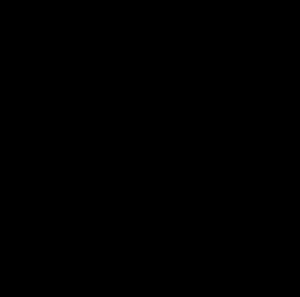

Iteration 0 : best score = 37644.06270483, mean score = 41126.45961616.


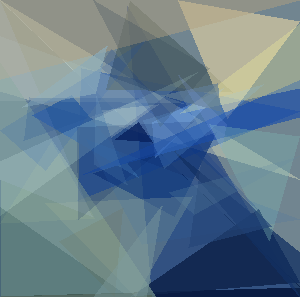

Iteration 5000 : best score = 960.69012346, mean score = 975.65979012.


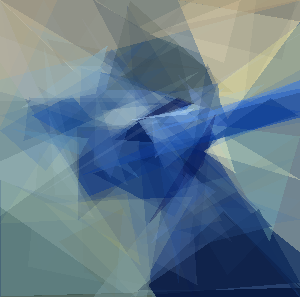

Iteration 10000 : best score = 683.07673401, mean score = 692.18369697.


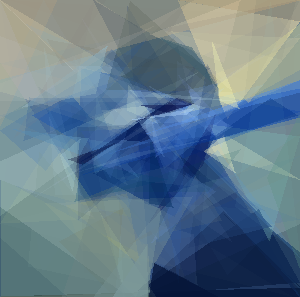

Iteration 15000 : best score = 530.36955107, mean score = 563.53747811.


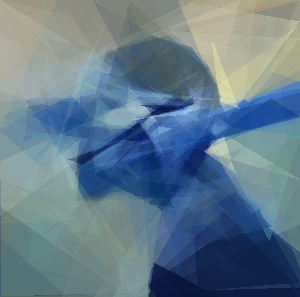

Iteration 20000 : best score = 471.53860831, mean score = 496.75198429.


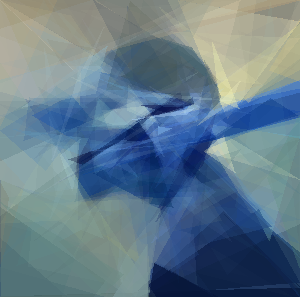

Iteration 25000 : best score = 428.85717172, mean score = 442.56728395.


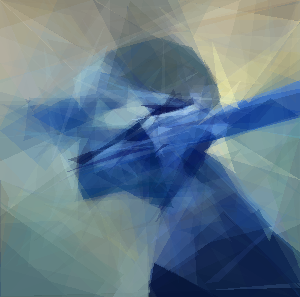

Iteration 30000 : best score = 390.83920314, mean score = 407.80891358.


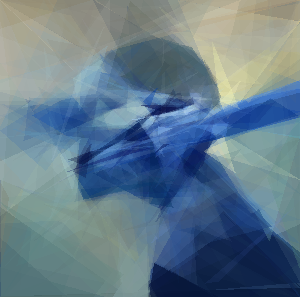

Iteration 35000 : best score = 369.24732884, mean score = 382.79832884.


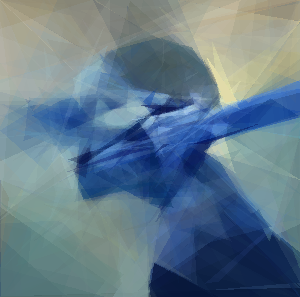

Iteration 40000 : best score = 348.62024691, mean score = 376.20559147.


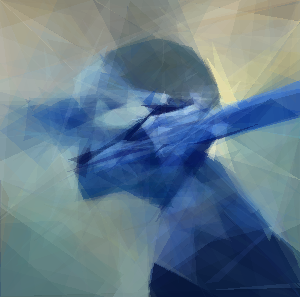

Iteration 45000 : best score = 326.12539843, mean score = 344.43058698.


In [25]:
beksinski.evolve(debug=True)

Lowes obj value: 309.3523120089787


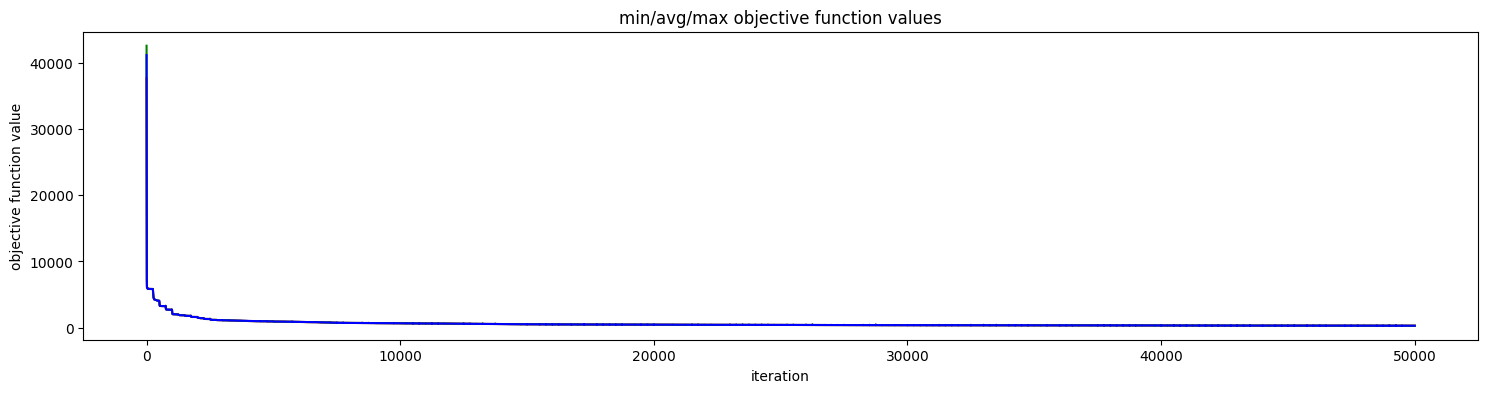

In [26]:
beksinski.show_statistics()

In [27]:
beksinski.save_results('beksinski_evo')

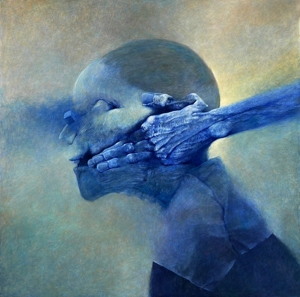

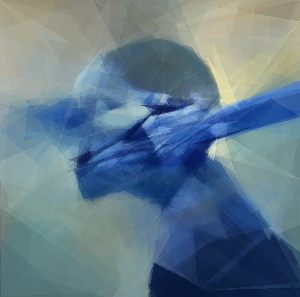

In [28]:
beksinski.show_image(beksinski.A)
beksinski.show_image(beksinski.result)

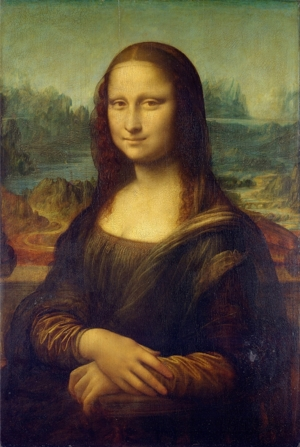

In [17]:
mona_lisa = BetterThanAdolf('mona_lisa.jpg', *args)
mona_lisa.show_image(mona_lisa.A)

  0%|          | 0/50000 [00:00<?, ?it/s]

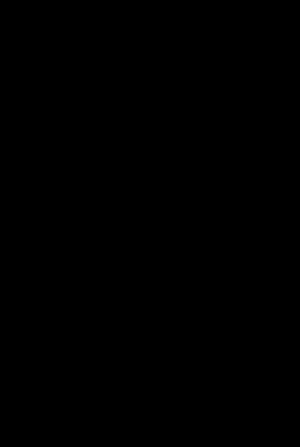

Iteration 0 : best score = 18886.52043997, mean score = 19115.67164057.


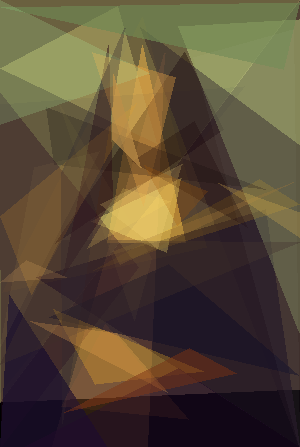

Iteration 5000 : best score = 853.00267711, mean score = 886.14175317.


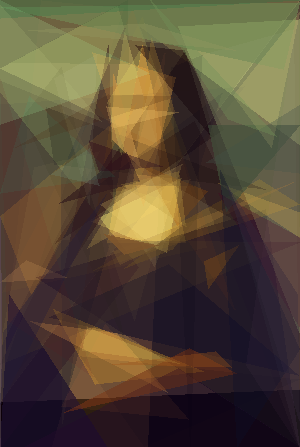

Iteration 10000 : best score = 564.81108874, mean score = 595.28746682.


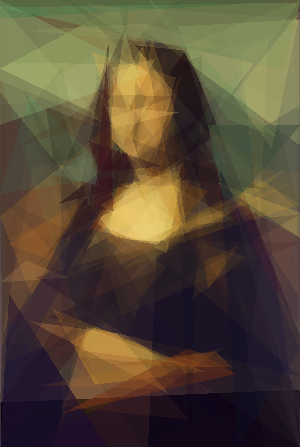

Iteration 15000 : best score = 473.04648024, mean score = 497.69056376.


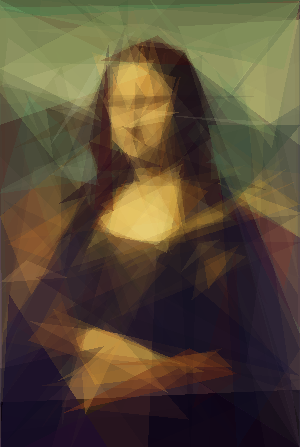

Iteration 20000 : best score = 403.70194631, mean score = 429.57401641.


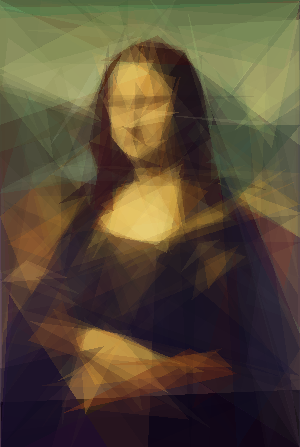

Iteration 25000 : best score = 359.78906040, mean score = 377.06781805.


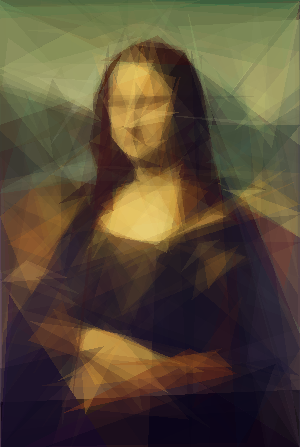

Iteration 30000 : best score = 327.52273676, mean score = 369.20239075.


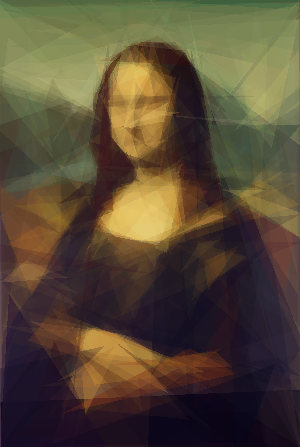

Iteration 35000 : best score = 302.85414616, mean score = 319.18189560.


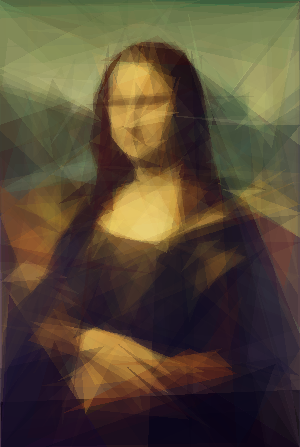

Iteration 40000 : best score = 282.33614467, mean score = 289.56804325.


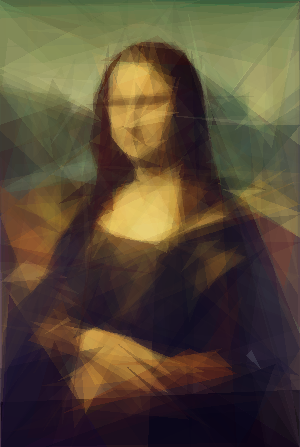

Iteration 45000 : best score = 268.43696495, mean score = 301.88102535.


In [18]:
mona_lisa.evolve(debug=True)

Lowes obj value: 257.1779642058166


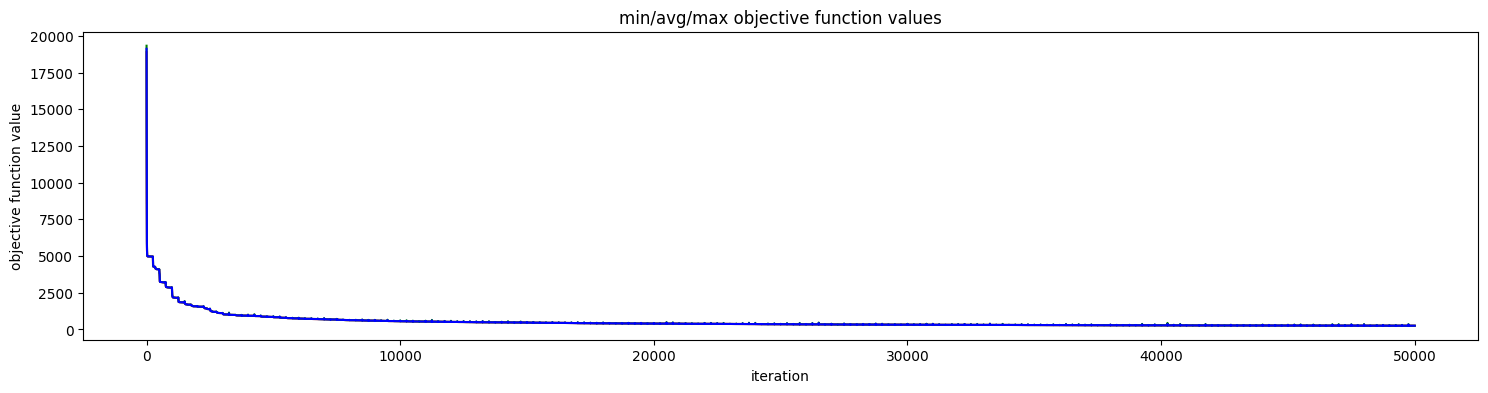

In [20]:
mona_lisa.show_statistics()

In [21]:
mona_lisa.save_results('mona_lisa_evo')

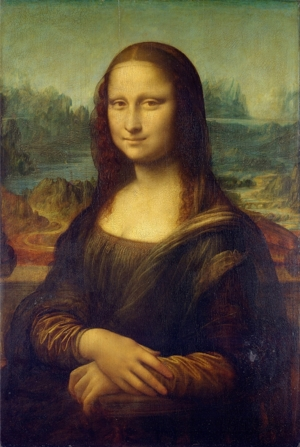

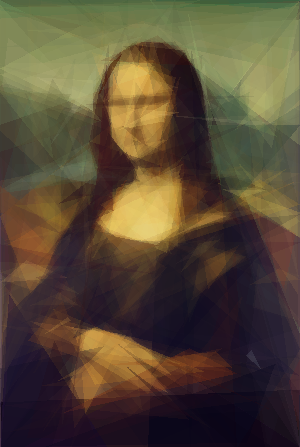

In [22]:
mona_lisa.show_image(mona_lisa.A)
mona_lisa.show_image(mona_lisa.result)